# A Comprehensive Twitter US Airline Sentiment Analysis


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
#from plotnine import ggplot, aes, geom_line
#from PIL import Image

import re
import os
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from textblob.classifiers import NaiveBayesClassifier
%matplotlib inline

In [8]:
plt.figure(figsize=(10,8));

<Figure size 720x576 with 0 Axes>

In [9]:
df = pd.read_csv('../Datasets/Tweets.csv')
df.sample(4)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11403,568139253194067968,negative,1.0000,Customer Service Issue,0.6596,US Airways,NaN,Kurt_Wirth,NaN,0,"@USAirways Doubt it. Gate 35x is a cluster, an...",NaN,2015-02-18 12:05:28 -0800,"ÜT: 43.182918,-77.651224",Eastern Time (US & Canada)
1193,569900131488632832,negative,1.0000,Late Flight,1.0000,United,NaN,kermudgeon,NaN,0,@united Why isn't the flight status updated to...,NaN,2015-02-23 08:42:34 -0800,Colorado,America/Chicago
5421,569104886119297024,neutral,0.6269,NaN,NaN,Southwest,NaN,MichelleMSmart,NaN,0,@SouthwestAir flt 3260 out of mht. Have fun wi...,NaN,2015-02-21 04:02:32 -0800,NaN,Eastern Time (US & Canada)
5590,568880408701435904,neutral,1.0000,NaN,NaN,Southwest,NaN,itsangieohyeah,NaN,0,@SouthwestAir I'm on the 110 lol has anyone ar...,NaN,2015-02-20 13:10:33 -0800,Dodger Stadium | Disneyland,Pacific Time (US & Canada)


## Exploratory Data Analysis (EDA)

In [10]:
# Some quick infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


Text(0.5, 1.0, 'Summary of Global Sentiment')

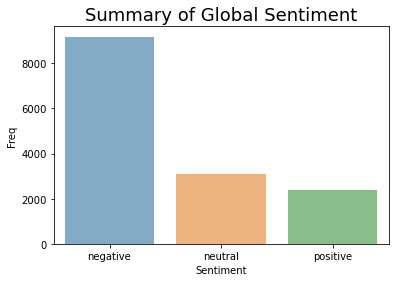

In [11]:
# summary of global sentiment
sns.countplot(x=df['airline_sentiment'].sort_values() , alpha=.6)
plt.ylabel('Freq')
plt.xlabel('Sentiment')
plt.title('Summary of Global Sentiment', fontsize=18)

In [12]:
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [13]:
# Tweets per airline in percent
tweets_per_airline = (df[['airline', 'text']].groupby('airline').count()/len(df['text'].notna().notnull())).sort_values(by='text', ascending=False)
tweets_per_airline

,text
airline,
United,0.261066
US Airways,0.198975
American,0.188456
Southwest,0.165301
Delta,0.151776
Virgin America,0.034426


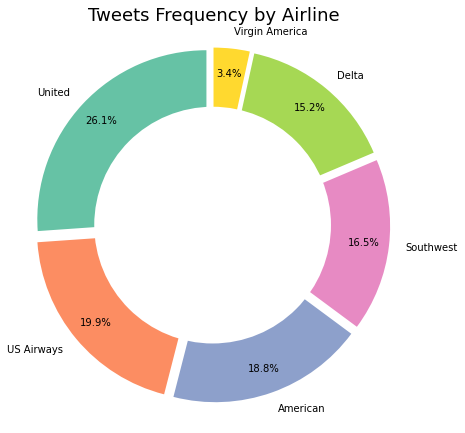

In [14]:
 
# Pie Chart of normalized tweets frequency for each airline
# Although, it is not recommended to use pie chart as visualization, 
# since they could be confusing and hard to understand, it doesn't hurt
# to learn how to do it

#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#33ccff', '#ff6600']
colors = sns.color_palette('Set2',10)
fig1, ax1 = plt.subplots(figsize=(6.5, 6))
plt.pie(tweets_per_airline.text, labels=tweets_per_airline.index.values, autopct='%1.1f%%', 
startangle=90, colors=colors,
pctdistance=0.85, explode = [0.05]*tweets_per_airline.shape[0])
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
ax1.axis('equal')  
plt.tight_layout()
plt.title('Tweets Frequency by Airline', fontsize=18,);

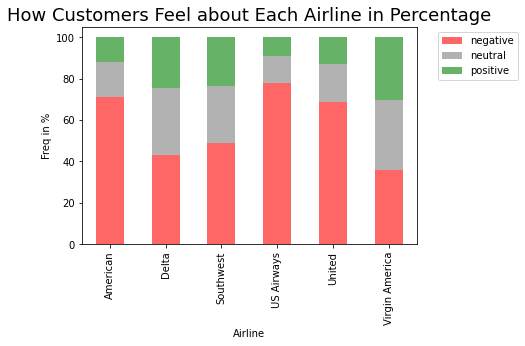

In [15]:
# Plot sentiment rates per airline
_ = pd.crosstab(df.airline, df.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar',
                title='How Customers Feel about Each Airline in Percentage', 
                stacked=True,
                color=['red', 'grey', 'green'], alpha=0.6 )

_.title.set_size(18)
_.set_xlabel('Airline')
_.set_ylabel('Freq in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

From the above figure we can already see that Virgin America has the best customer sentiment and US Airways the worst. Indeed, between 2012 and 2014, Virgin America was ranked as the best airline carrier in the US. However, it was struggling to attain profits and didn't make it beyond 2018. From the number of tweets we can also tell that Virgin America was a small startup airline at that time, with only 500 tweets in comparaison to almost 3000 tweets about US Airways.

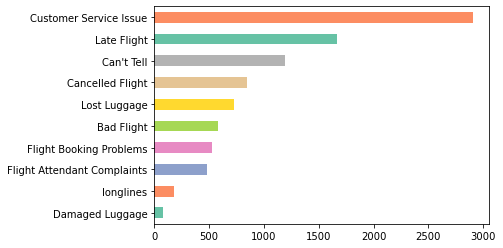

In [16]:
# Let's dig more into the negative reviews
colors = sns.color_palette('Set2',df['negativereason'].nunique())
df['negativereason'].value_counts().sort_values().plot(kind='barh', color=colors);

There are 10 different reasons for negative reviews. The most important ones are:

1. Customer Service Issue with almost 3000 tweets
2. Late flight (Nr of tweets= 1665)
3. Can't tell, which means the overall flight experience with more than 1100 tweets.


In [119]:
# Generate a dataframe with negative reasons rates per carrier for all 6 carriers
neg_rev = pd.DataFrame(index=df['negativereason'].dropna().unique())
for air in tweets_per_airline.index:
    neg_rev[air] = df[df['airline'] == air]['negativereason'].value_counts(normalize=True)*100

neg_rev.max()

United            25.864033
US Airways        35.837384
American          39.183673
Southwest         32.967960
Delta             28.167539
Virgin America    33.149171
dtype: float64

In [113]:
# number of variable
categories = list(neg_rev.index)
N = len(categories)
categories

['Bad Flight',
 "Can't Tell",
 'Late Flight',
 'Customer Service Issue',
 'Flight Booking Problems',
 'Lost Luggage',
 'Flight Attendant Complaints',
 'Cancelled Flight',
 'Damaged Luggage',
 'longlines']

In [114]:
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

In [118]:
neg_rev

,United,US Airways,American,Southwest,Delta,Virgin America
Bad Flight,8.203570,4.595669,4.438776,7.588533,6.701571,10.497238
Can't Tell,14.394227,10.870526,10.102041,13.406408,19.476440,12.154696
Late Flight,19.939233,20.017676,12.704082,12.816189,28.167539,9.392265
Customer Service Issue,25.864033,35.837384,39.183673,32.967960,20.837696,33.149171
Flight Booking Problems,5.469047,5.391074,6.632653,5.143339,4.607330,15.469613
Lost Luggage,10.216483,6.805126,7.602041,7.588533,5.968586,2.762431
Flight Attendant Complaints,6.380555,5.435263,4.438776,3.204047,6.282723,2.762431
Cancelled Flight,6.874288,8.351745,12.551020,13.659359,5.340314,9.944751
Damaged Luggage,0.835549,0.486080,0.612245,1.180438,1.151832,2.209945
longlines,1.823016,2.209456,1.734694,2.445194,1.465969,1.657459


In [157]:
# We are going to plot the first column of the data frame.
# But we need to repeat the first value to close the circular graph:
values = neg_rev.values
values = np.append(values, [values[0,:]], axis=0)
labels = neg_rev.columns.values
labels

array(['United', 'US Airways', 'American', 'Southwest', 'Delta',
       'Virgin America'], dtype=object)

In [164]:
for y_arr, label in zip(values.T, labels):
    print(y_arr, label)

[ 8.20357007 14.39422712 19.93923281 25.86403342  5.46904671 10.2164831
  6.3805545   6.87428788  0.8355488   1.82301557  8.20357007] United
[ 4.59566947 10.87052585 20.01767565 35.837384    5.3910738   6.80512594
  5.43526293  8.35174547  0.48608042  2.20945647  4.59566947] US Airways
[ 4.43877551 10.10204082 12.70408163 39.18367347  6.63265306  7.60204082
  4.43877551 12.55102041  0.6122449   1.73469388  4.43877551] American
[ 7.58853288 13.40640809 12.81618887 32.96795953  5.14333895  7.58853288
  3.20404722 13.65935919  1.18043845  2.44519393  7.58853288] Southwest
[ 6.70157068 19.47643979 28.16753927 20.83769634  4.60732984  5.96858639
  6.28272251  5.34031414  1.15183246  1.46596859  6.70157068] Delta
[10.49723757 12.15469613  9.39226519 33.14917127 15.46961326  2.76243094
  2.76243094  9.94475138  2.20994475  1.65745856 10.49723757] Virgin America


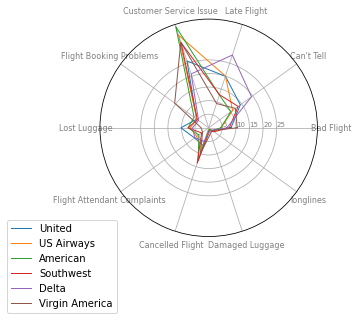

In [165]:
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5,10,15,20,25], ["5","10","15",'20','25'], color="grey", size=7)
plt.ylim(0,40)
# Plot data
for y_arr, label in zip(values.T, labels):
    ax.plot(angles, y_arr, linewidth=1, linestyle='solid', label=label)
# Fill area
#ax.fill(angles, values, 'b', alpha=0.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),)
# Show the graph
plt.show()

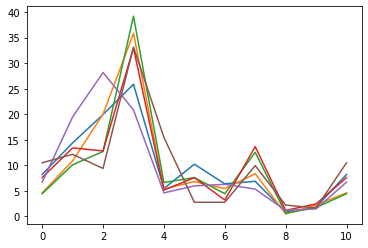

In [156]:
# Draw one axe per variable + add labels
plt.plot(values)

In [75]:
b

array(['Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

In [65]:
b.dtype

dtype('int64')

In [68]:
df[df['airline'] == air]['negativereason'].value_counts(normalize=True)

Customer Service Issue         0.331492
Flight Booking Problems        0.154696
Can't Tell                     0.121547
Bad Flight                     0.104972
Cancelled Flight               0.099448
Late Flight                    0.093923
Flight Attendant Complaints    0.027624
Lost Luggage                   0.027624
Damaged Luggage                0.022099
longlines                      0.016575
Name: negativereason, dtype: float64